In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D,Dense,InputLayer,Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError,Huber,MeanAbsoluteError,BinaryCrossentropy

In [3]:
dataset,dataset_info = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

In [4]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1

In [5]:
def split(dataset,TRAIN_RATIO,TEST_RATIO,VAL_RATIO):

  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))


  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))


  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))

  return train_dataset,test_dataset,val_dataset




In [6]:
train_dataset,test_dataset,val_dataset = split(dataset[0],TRAIN_RATIO,TEST_RATIO,VAL_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()))
print(list(test_dataset.take(1).as_numpy_iterator()))
print(list(val_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), np.int64(0))]
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0,

Data Visualization

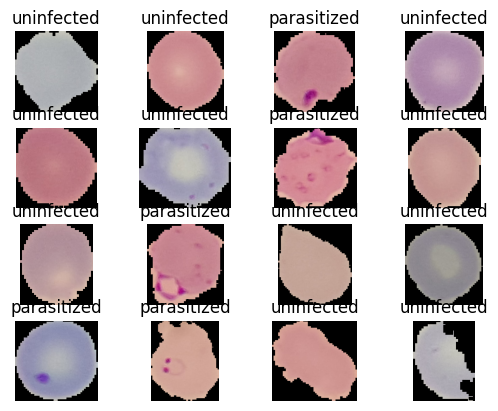

In [7]:
for i,(image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [8]:
dataset_info.features['label'].int2str(0)

'parasitized'

Data Preprocessing


In [9]:
IM_SIZE = 224
def resize_rescale(image,label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0,label

In [10]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [11]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


In [12]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True,).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:

val_dataset = val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True,).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [15]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [16]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),
    Conv2D(filters = 6, kernel_size = 3, strides=1,padding='valid',activation='relu'),
     BatchNormalization(),
    MaxPool2D(pool_size=2,strides=1),



    Conv2D(filters = 16, kernel_size = 5, strides=1,padding='valid',activation='relu'),
     BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Flatten(),
    Dense(100, activation = "relu"),
    Dense(10, activation = "relu"),
    Dense(1, activation = "sigmoid"),

])

model.summary()




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 221, 221, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 217, 217, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 217, 217, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 108, 108, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    18,662,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,666,193 (71.21 MB)

 Trainable params: 18,666,149 (71.21 MB)

 Non-trainable params: 44 (176.00 B)

In [18]:
model.compile(optimizer=Adam(learning_rate=0.1),
              loss = BinaryCrossentropy(),
              metrics = ['accuracy'])


In [24]:
history = model.fit(train_dataset, validation_data = val_dataset,epochs = 20, verbose=1)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 44s 63ms/step - accuracy: 0.4988 - loss: 0.6954 - val_accuracy: 0.5053 - val_loss: 0.6931
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 79s 60ms/step - accuracy: 0.4955 - loss: 0.6953 - val_accuracy: 0.5064 - val_loss: 0.6931
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 48s 70ms/step - accuracy: 0.4962 - loss: 0.6954 - val_accuracy: 0.5038 - val_loss: 0.6931
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 73s 58ms/step - accuracy: 0.4984 - loss: 0.6955 - val_accuracy: 0.5071 - val_loss: 0.6931
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.4937 - loss: 0.6956 - val_accuracy: 0.5049 - val_loss: 0.6932
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.4977 - loss: 0.6951 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.4975 - loss: 0.6953 - val_accuracy: 0.5049 - val_loss: 0.6932
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - accuracy: 0.4977 - loss: 0.6955 - 

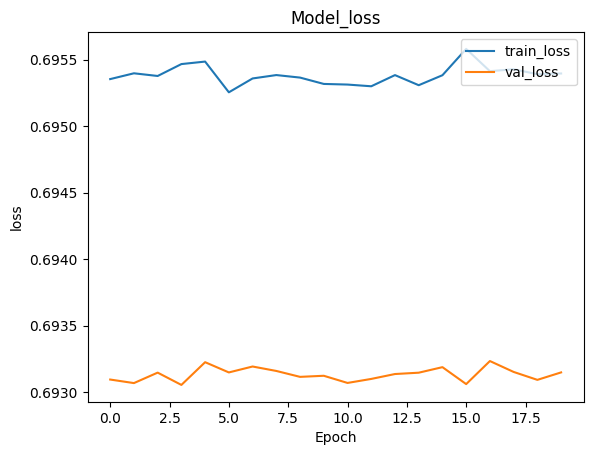

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train_loss','val_loss'],loc='upper right')
plt.show()

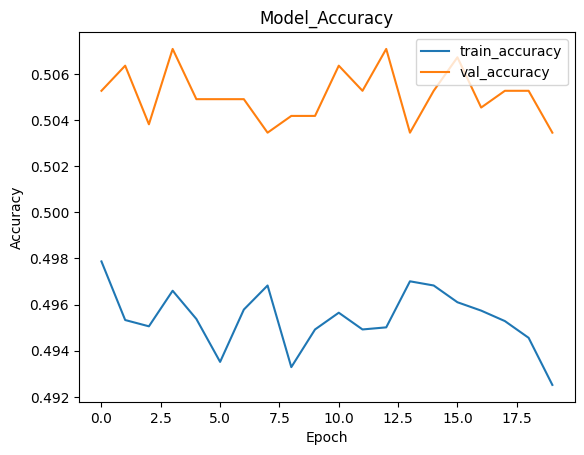

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy','val_accuracy'],loc='upper right')
plt.show()

Model Evaluation and Testing

In [31]:
test_dataset = test_dataset.batch(1)

In [35]:
model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.5056 - loss: 0.6931


[0.6933866143226624, 0.49474066495895386]

In [36]:
def parasite_or_not(x):
  if(x<0.5):
    return str("P")
  else:
    return str("U")

In [37]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


'U'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


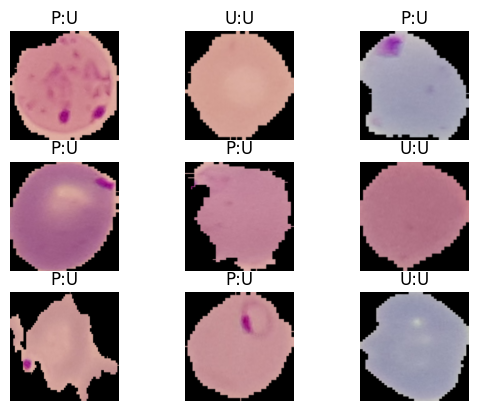

In [39]:
for i,(image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')